# Exploration 11. 페렴 진단  (Pneumonia Diagnosis)

의료 인공지능은 다양한 분야에서 사용되고 있다. 질병의 정확한 분류 또는 환자의 중등도를 확인하는 용도 등 다양한 용도로 사용된다.  

이 중에서 현재 가장 핫한 분야는 __질병을 탐지해내는 인공지능__ 이다.  

[캐글의 Chest X-Ray Images](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) 데이터셋을 사용하여 폐렴(Pneumonia)을 찾아내는 딥러닝 모델을 만들어보자.

### 폐렴 구별법
폐렴(pneumonia 뉴모니아)은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병이다.  
X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰되면 폐렴으로 구분한다.
![image](https://user-images.githubusercontent.com/84179578/129993290-8ad7a99f-5cf8-4383-a9a6-1f2f0b4ae37e.png)

- __정상적인 흉부__ (왼쪽) : 비정상적인 음영 영역이 없는 깨끗한 폐
- __세균성 폐렴__ (가운데) : 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 나타남
- __바이러스성 폐렴__ (오른쪽) : 양쪽 폐에서 보다 확산된 interstitial(조직 사이에 있는) 패턴으로 나타남

이러한 X-RAY 이미지에서 폐렴의 특징 패턴을 학습해서 찾아내 폐렴인지 아닌지에 진단을 내릴 수 있는 딥러닝 모델을 만들어보자.

----
## 0. 필요한 모듈 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

----
## 1. 데이터 준비


In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


BATCH_SIZE = 16
EPOCHS = 25

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(f'train 개수: {len(train_filenames)}')
print(f'validation 개수 : {len(val_filenames)}')
print(f'test 개수 : {len(test_filenames)}')

train 개수: 5216
validation 개수 : 16
test 개수 : 624


val 개수가 너무 적기 때문에 train 과 val 에 있는 데이터를 모은 다음에 8:2 로 분할한다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(f'train 개수: {len(train_filenames)}')
print(f'validation 개수 : {len(val_filenames)}')
print(f'test 개수 : {len(test_filenames)}')

train 개수: 4185
validation 개수 : 1047
test 개수 : 624


In [13]:
# 파일 경로 확인
for i in range(10):    
    print(f'image path : {filenames[i]}')

image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person542_virus_1072.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person25_bacteria_116.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1648_bacteria_4375.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1484_bacteria_3878.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1486_bacteria_3884.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person407_bacteria_1822.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person23_bacteria_103.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1376_virus_2367.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1482_virus_2572.jpeg
image path : /aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0846-0001.jpeg


파일 경로을 확인해보면 정상 이미지는 `NORMAL` 에 속해있고, 폐렴 이미지는 `PNEUMONIA` 에 속해있는 것을 알 수 있다.

In [14]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1074
Pneumonia images count in training set: 3111


정상보다 폐렴 이미지 수가 3배 더 많이 있다.  

CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘한다.  

데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정이다.

배치처리 작업을 보다 효율적으로 할 수 있도록 `tf.data` 인스턴스를 만들자.

In [15]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [16]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지 데이터에는 라벨 데이터가 없다.  

파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들자.

In [17]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄인다.  

이를 위해 `decode_img` 와 `process_path` 함수를 정의한다.

In [18]:
# 이미지를 알맞은 형식으로 바꾼다
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만든다.  

`num_parallel_calls` 파라미터에서 `set-up`에서 초기화 한 `AUTOTUNE` 을 이용하면 더욱 빠르게 데이터를 처리해준다.

In [19]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [20]:
# resizae, labeling 된 이미지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어보자.

In [21]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# test 데이터 개수 확인
print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다. 

밑에 있는 `prepare_for_training()` 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시킨다.
- `shuffle()` :고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- `repeat()` : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 `repeat()`를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용
- `batch()` : BATCH_SIZE에서 정한 만큼의 배치로 주어짐
- `prefetch()` : 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음

In [22]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

----
## 2. 데이터 시각화

 train에 있는 batch 중 첫 번째 배치를 추출하여 배치를 image와 label 데이터 셋으로 나눈다.  그 후 `show_batch()` 함수를 이용해서 결과 사진을 보자.

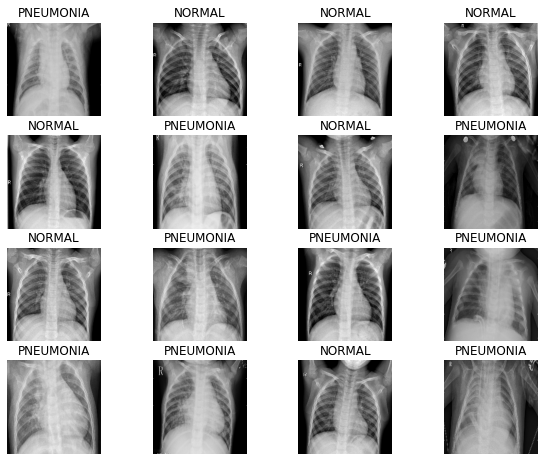

In [23]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여준다
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

----
## 3. CNN 모델 생성

먼저, Convolution block을 만든다.  

`conv_block()` 의 구성은 아래와 같다.
- Convolution 두 번 진행
- Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
- Max pooling


In [24]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

Dense Block은 아래와 같이 만든다.

In [25]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있다.  
이 후 위 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부를 살펴보겠다.

In [26]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

----
## 4. 데이터 imbalance 처리

한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용된다.  

Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다.  

`Keras는 model.fit()`을 호출할 때 파라미터로 넘기는 `class_weight` 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있다.

weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정한다.
- `weight_for_0` : Normal 이미지에 사용할 weight
- `weight_for_1` : Pneumonia 이미지에 사용할 weight

In [27]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


----
## 5. 모델 훈련
- 이미지 훈련은 GPU를 사용할 것이기 때문에 GPU를 선택
- 모델은 위에서 만들었던 모델 함수인 `build_model()` 선언
- 이미지의 라벨이 두 개밖에 없기 때문에 `binary_cross entropy` loss를 사용
- optimizer로 `adam`을 사용
- 성과에 대해서 측정하기 위한 metrics으로 `accuracy`, `precision`, `recall`을 사용

In [28]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어서 모델을 fit 한다.

In [29]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 52s 141ms/step - loss: 0.5301 - accuracy: 0.7135 - precision: 0.9027 - recall: 0.6842 - val_loss: 0.7057 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 35s 133ms/step - loss: 0.2200 - accuracy: 0.9214 - precision: 0.9754 - recall: 0.9186 - val_loss: 1.5378 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 35s 133ms/step - loss: 0.1943 - accuracy: 0.9188 - precision: 0.9780 - recall: 0.9130 - val_loss: 0.1290 - val_accuracy: 0.9490 - val_precision: 0.9451 - val_recall: 0.9883
Epoch 4/25
261/261 [==============================] - 35s 135ms/step - loss: 0.1699 - accuracy: 0.9352 - precision: 0.9796 - recall: 0.9317 - val_loss: 0.5600 - val_accuracy: 0.7981 - val_precision: 1.0000 - val_recall: 0.7266
Epoch 5/25
261/261 [==============================] - 35s 134ms/step - loss: 0.1404 - accura

----
## 6. 결과 확인

그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보자.

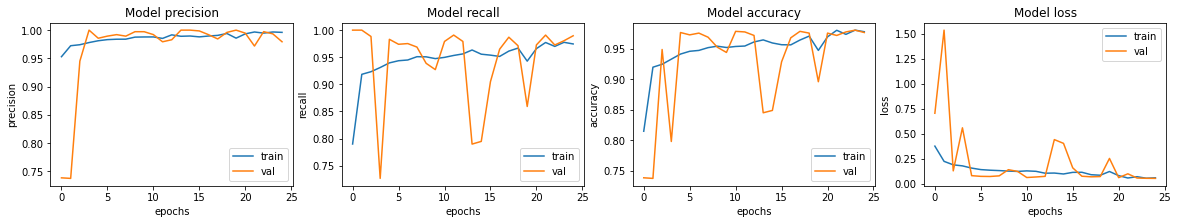

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델을 평가해보자.

In [31]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 76ms/step - loss: 1.3145 - accuracy: 0.7324 - precision: 0.7009 - recall: 0.9974
Loss: 1.3145158290863037,
Accuracy: 0.7323718070983887,
Precision: 0.7009009122848511,
Recall: 0.9974358677864075


페렴 진단에 있어서 약 70% 정도는 맞추는것을 확인 할 수 있다.


의료 데이터의 경우 구하기도 어렵고 구하더라도 데이터가 작은 경우가 많이 있다. 이런 문제를 해결하기 위해 Data augmentation 방법을 많이 시도한다.  

위과정에서도 data augmentation 과정을 추가하면 성능이 더 개선될 것으로 보인다.